In [23]:
!pip install scipy

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.4 kB 129.6 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.4 kB 217.9 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 266.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/44.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/44.1 MB 2.3 MB/s eta 0:00:20
   ---------------------------------------- 0.5/44.1 MB 6.6 MB/s eta 0:00:07
   - -------------------------------------- 1.5/44.1 MB 11.9 MB/s eta 0:00:04
   - -------------------------------------- 2.2/44.1 MB 15.4 MB/s eta 0:00:03
   ---- ----------------------------------- 5.0/44.1 MB 21.4 MB/s eta 0:00:02
   ----- ---------------------------------- 6.4/44.1 MB 24.1 MB/s eta 0:00:02
   ---

In [4]:
!pip install requests
!pip install bs4
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

     ---------------------------------------- 0.0/61.5 kB ? eta -:--:--
     ---------------------------------------  61.4/61.5 kB 1.6 MB/s eta 0:00:01
     ---------------------------------------- 61.5/61.5 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/62.6 kB ? eta -:--:--
   ---------------------------------------- 62.6/62.6 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/158.3 kB ? eta -:--:--
   ---------------------------------------- 158.3/158.3 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/97.8 kB ? eta -:--:--
   ---------------------------------------- 97.8/97.8 kB 5.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/123.8 kB ? eta -:--:--
   ---------------------------------------- 123.8/123.8 kB 7.1 MB/s eta 0:00:00
  Using cached bs4-0.0.1-py3-none-any.whl
     ---------------------------------------- 0.0/143.0 kB ? eta -:--:--
     ----------------------------------- -- 133.1/143.0

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import re

In [1]:
# Get a list of all the urls for the avalanche reports for Salt-Lake
page_numbers = range(17) #0 - 16 inclusive
url_base = 'https://utahavalanchecenter.org/archives/forecasts/salt-lake?page='
urls = [url_base + str(page_number) for page_number in page_numbers]

sub_urls = []


# REQUESTS
for website in urls:
    response = requests.get(website)
    soup = BeautifulSoup(response.content, 'html.parser')
    links = soup.find_all('a')
    for link in links:
        print(link.get('href'))
        sub_urls.append(link.get('href'))

pd.DataFrame(sub_urls).to_csv('sub_urls.csv')


https://store.utahavalanchecenter.org/collections/events-1
https://www.mammut.com/
/
/observations-avalanches/submit
None
/forecast/logan
/forecast/ogden
/forecast/salt-lake
/forecast/provo
/forecast/uintas
/forecast/skyline
/forecast/moab
/forecast/abajos
/node/13549
/archives/forecasts
/node/41482
/node/13652
/observations
/avalanches
/avalanches/fatalities
http://wasatchbackcountryskiing.com/
/node/16726
/node/69813
/node/70741
/node/69815
/node/70744
https://store.utahavalanchecenter.org/collections/events-1
https://store.utahavalanchecenter.org/
/node/21578
/node/13544
https://utahavalanchecenter.org/core-values
/node/13545
/node/13546
/node/39841
/node/39875
/node/16727
/user/login
/node/39859
/join
/forecast/logan
/forecast/ogden
/forecast/salt-lake
/forecast/provo
/forecast/uintas
/forecast/skyline
/forecast/moab
/forecast/abajos
/node/13549
/archives/forecasts
/node/41482
/node/13652
/observations
/avalanches
/avalanches/fatalities
http://wasatchbackcountryskiing.com/
/node/16

In [7]:
# Clean the data and put it into a dataframe
df = pd.read_csv('resources/sub_urls.csv')
df.columns = ['index', 'url']

# filter urls with prefix 'https://utahavalanchecenter.org/forecast/salt-lake/'
df = df[df['url'].str.startswith('https://utahavalanchecenter.org/forecast/salt-lake/')]
df = df.reset_index(drop=True)
df['url'] = df['url'].str.replace('https://utahavalanchecenter.org/forecast/salt-lake/', '')


ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [11]:
# More cleaning
prefix = '/forecast/salt-lake/'
df = df.fillna('') # fill NaNs with empty string
df = df[df['url'].str.startswith(prefix)]
df = df.reset_index(drop=True)
base = 'https://utahavalanchecenter.org'
df['url'] = base + df['url']

NameError: name 'df' is not defined

In [15]:
# Drop duplicates and save to csv
df.drop_duplicates(subset=['url'], inplace=True)
df = df.reset_index(drop=True)
df.to_csv('daily_reports_urls.csv', index=False)

In [8]:
df = pd.read_csv('resources/daily_reports_urls.csv')

In [9]:
def get_page_source(url):
    response = requests.get(url)
    page_source = response.content
    return page_source

In [10]:
page_source = get_page_source('https://utahavalanchecenter.org/forecast/salt-lake/2/27/2023')

In [11]:
# first link will be the overall forecast image
def get_rose_image_links(page_source):
    # find all links that start with '/sites/default/files/forecast/'
    links = re.findall(r'<img.*?src="/(sites/default/files/forecast/.*?)">', page_source.decode('utf-8'))
    # append 'https://utahavalanchecenter.org' to the beginning of each link
    links = ['https://utahavalanchecenter.org/' + link for link in links]
    return links

links = get_rose_image_links(page_source)


In [12]:
def get_color(image, pixel_location):
    return image.getpixel(pixel_location)

In [13]:
def load_image(url):
    return Image.open(requests.get(url, stream=True).raw)

In [14]:
def show_image(image):
    plt.imshow(image)
    plt.show()

In [15]:
def classify_color(rgba):
    color_map = {
        'red': (237, 28, 36, 255), # High
        'orange': (247, 148, 30, 255), # Considerable
        'yellow': (255, 242, 0, 255), # Moderate
        'green': (80, 184, 72, 255), # Low
        'blue': (68, 187, 238, 255), #
        'gray': (192, 192, 192, 255), # 
        'white': (255, 255, 255, 255), #'  
        'black': (0, 0, 0, 255), # Extreme
        'transparent': (0, 0, 0, 0) #
    }
    # Get the color with the smallest distance from the given color
    from scipy.spatial import distance
    distances = []
    for color in color_map.values():
        distances.append(distance.euclidean(rgba, color))
    min_index = np.argmin(distances)
    return list(color_map.keys())[min_index]

In [16]:
def get_forecast_level(image, pixel_locations):
    # Get the color at each pixel for a list of pixel locations
    colors = []
    for location in pixel_locations:
        rgba = get_color(image, location)
        color = classify_color(rgba)
        colors.append(color)
    return colors

In [17]:
def get_forecast_from_image(image):
    pixel_map = {
        'high': {
            'N': (200, 132),
            'NE': (220, 132),
            'E': (240, 154),
            'SE': (220, 176),
            'S': (200, 176),
            'SW': (180, 176),
            'W': (160, 154),
            'NW': (180, 132)
        },
        'mid': {
            'N': (200, 110),
            'NE': (240, 110),
            'E': (270, 154),
            'SE': (240, 220),
            'S': (200, 230),
            'SW': (140, 198),
            'W': (120, 154),
            'NW': (140, 110),
        },
        'low': {
            'N': (200, 66),
            'NE': (300, 110),
            'E': (320, 176),
            'SE': (280, 264),
            'S': (200, 286),
            'SW': (100, 242),
            'W': (80, 176),
            'NW': (100, 110),
        },    
    }
    forecast = {}
    for level, pixel_locations in pixel_map.items():
        forecast[level] = get_forecast_level(image, pixel_locations.values())
    return forecast

In [18]:
def get_forecast_from_url(image_url):
    image = load_image(image_url)
    forecast = get_forecast_from_image(image)
    return forecast


In [19]:
def get_danger_level(level_forecast):
    danger_map = {
        'black': 4,
        'red': 3,
        'orange': 2,
        'yellow': 1,
        'green': 0,
    }
    dangers = [danger_map[danger] for danger in level_forecast]
    for key, value in danger_map.items():
        if value == max(dangers):
            return key
    return None

In [25]:
links

['https://utahavalanchecenter.org/sites/default/files/forecast/202302/20230227-074409-6.png',
 'https://utahavalanchecenter.org/sites/default/files/forecast/202302/20230227-074409-1.png',
 'https://utahavalanchecenter.org/sites/default/files/forecast/202302/20230227-074409-3.png']

In [20]:
image = load_image(links[1])

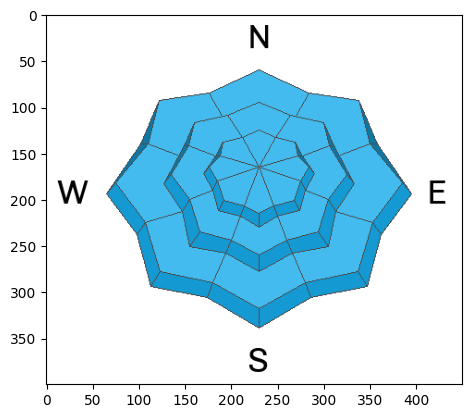

In [21]:
show_image(image)

In [ ]:
def get_avalanche_problem_from_image(image):
    avalanche_danger_map = {
        'high': {
            'N': (230, 140),
            'NE': (250, 140),
            'E': (264, 160),
            'SE': (250, 180),
            'S': (230, 200),
            'SW': (210, 180),
            'W': (200, 160),
            'NW': (210, 140)
        },
        'mid': {
            'N': (230, 120),
            'NE': (286, 120),
            'E': (307, 160),
            'SE': (286, 220),
            'S': (230, 240),
            'SW': (176, 220),
            'W': (154, 170),
            'NW': (176, 120),
        },
        'low': {
            'N': (230, 80),
            'NE': (308, 100),
            'E': (352, 180),
            'SE': (330, 260),
            'S': (230, 300),
            'SW': (132, 260),
            'W': (110, 180),
            'NW': (132, 100),
        },   
    }
    forecast = {}
    for level, pixel_locations in avalanche_danger_map.items():
        forecast[level] = get_forecast_level(image, pixel_locations.values())
    return forecast

In [31]:
def extract_avalanche_problems(page_source):
    soup = BeautifulSoup(page_source, 'html.parser')
    divs = soup.find_all('div', string=lambda t: t and 'Avalanche Problem #' in t)
    problems = []
    for div in divs:
        h5 = div.find_next_sibling('h5')
        if h5:
            problems.append(h5.text)
    return problems

def extract_locations(page_source):
    links = get_rose_image_links(page_source)
    location_links = links[1:]
    locations = []
    for link in location_links:
        locations.append(get_avalanche_problem_from_image(load_image(link)))
    return locations


def extract_likelihood_numbers(page_source):
    # Find all image links that contain 'likelihood' in the URL
    links = re.findall(r'<img.*?src="(.*?likelihood.*?)".*?>', page_source.decode('utf-8'))
    # Extract the number from each URL using regular expressions
    numbers = [re.search(r'likelihood_(\d+)\.jpg', link).group(1) for link in links]
    return numbers

def extract_size_numbers(page_source):
    # Find all image links that contain 'size' in the URL
    links = re.findall(r'<img.*?src="(.*?size.*?)".*?>', page_source.decode('utf-8'))
    # Extract the number from each URL using regular expressions
    numbers = [re.search(r'size_(\d+)\.jpg', link).group(1) for link in links]
    return numbers

def get_avalanche_problems(page_source):
    problem_types = extract_avalanche_problems(page_source)
    likelihood_numbers = extract_likelihood_numbers(page_source)
    size_numbers = extract_size_numbers(page_source)
    locations = extract_locations(page_source)
    problems = []
    for i in range(len(problem_types)):
        problem = {
            'type': problem_types[i],
            'likelihood': likelihood_numbers[i],
            'size': size_numbers[i],
            'location': locations[i]
        }
        problems.append(problem)
    
    return problems

In [33]:
get_avalanche_problems(page_source)[0]

{'type': 'New Snow',
 'likelihood': '02',
 'size': '02',
 'location': {'high': ['blue',
   'blue',
   'blue',
   'blue',
   'blue',
   'blue',
   'blue',
   'blue'],
  'mid': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'],
  'low': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']}}

In [34]:
def get_avalanche(url):
    page_source = get_page_source(url)
    links = get_rose_image_links(page_source)
    forecast = get_forecast_from_url(links[0])
    level_forecasts = [forecast['high'], forecast['mid'], forecast['low']]
    # get avalanche problems roses
    problems = get_avalanche_problems(page_source)
    return {
        'forecast': forecast,
        'level_forecasts': level_forecasts,
        'problems': problems,
    }

In [35]:
get_avalanche('https://utahavalanchecenter.org/forecast/salt-lake/3/2/2023')

{'forecast': {'high': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'mid': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'low': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']},
 'level_forecasts': [['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']],
 'problems': [{'type': 'Wind Drifted Snow',
   'likelihood': '02',
   'size': '04',
   'location': {'high': ['blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue'],
    'mid': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray'],
    'low': ['gray', 'gray', '

In [36]:
avalanche = pd.DataFrame(columns=['date', 
                                  'HN', 'HNE', 'HE', 'HSE', 'HS', 'HSW', 'HW', 'HNW', #overall risk
                                  'MN', 'MNE', 'ME', 'MSE', 'MS', 'MSW', 'MW', 'MNW',
                                  'LN', 'LNE', 'LE', 'LSE', 'LS', 'LSW', 'LW', 'LNW',
                                  'high', 'mid', 'low',
                                  'problem_1_type', 'likelihood_1', 'size_1',          #problem 1
                                  'HN1', 'HNE1', 'HE1', 'HSE1', 'HS1', 'HSW1', 'HW1', 'HNW1',
                                  'MN1', 'MNE1', 'ME1', 'MSE1', 'MS1', 'MSW1', 'MW1', 'MNW1',
                                  'LN1', 'LNE1', 'LE1', 'LSE1', 'LS1', 'LSW1', 'LW1', 'LNW1',
                                  'high1', 'mid1', 'low1',
                                  'problem_2_type', 'likelihood_2', 'size_2',          #problem 2
                                  'HN2', 'HNE2', 'HE2', 'HSE2', 'HS2', 'HSW2', 'HW2', 'HNW2',
                                  'MN2', 'MNE2', 'ME2', 'MSE2', 'MS2', 'MSW2', 'MW2', 'MNW2',
                                  'LN2', 'LNE2', 'LE2', 'LSE2', 'LS2', 'LSW2', 'LW2', 'LNW2',
                                  'high2', 'mid2', 'low2',
                                  'problem_3_type', 'likelihood_3', 'size_3',           #problem 3
                                  'HN3', 'HNE3', 'HE3', 'HSE3', 'HS3', 'HSW3', 'HW3', 'HNW3',
                                  'MN3', 'MNE3', 'ME3', 'MSE3', 'MS3', 'MSW3', 'MW3', 'MNW3',
                                  'LN3', 'LNE3', 'LE3', 'LSE3', 'LS3', 'LSW3', 'LW3', 'LNW3',
                                  'high3', 'mid3', 'low3',      
                            ])

In [38]:
ex = {'forecast': {'high': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'mid': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  'low': ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']},
 'level_forecasts': [['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow'],
  ['yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow',
   'yellow']],
 'problems': [{'type': 'Wind Drifted Snow',
   'likelihood': '02',
   'size': '04',
   'location': {'high': ['blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue'],
    'mid': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray'],
    'low': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']}},
  {'type': 'New Snow',
   'likelihood': '02',
   'size': '03',
   'location': {'high': ['blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue',
     'blue'],
    'mid': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'],
    'low': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']}},
  {'type': 'Wet Snow',
   'likelihood': '02',
   'size': '02',
   'location': {'high': ['gray',
     'gray',
     'gray',
     'blue',
     'blue',
     'blue',
     'gray',
     'gray'],
    'mid': ['gray', 'gray', 'gray', 'blue', 'blue', 'blue', 'gray', 'gray'],
    'low': ['gray', 'gray', 'gray', 'blue', 'blue', 'blue', 'gray', 'gray']}}]}


In [ ]:
# {'high': ['blue',
#      'blue',
#      'blue',
#      'blue',
#      'blue',
#      'blue',
#      'blue',
#      'blue'],
#     'mid': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray'],
#     'low': ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']}
def lists_to_dict(lists):
    keys = {'high': ['HN', 'HNE', 'HE', 'HSE', 'HS', 'HSW', 'HW', 'HNW',],
            'mid': ['MN', 'MNE', 'ME', 'MSE', 'MS', 'MSW', 'MW', 'MNW',],
            'low': ['LN', 'LNE', 'LE', 'LSE', 'LS', 'LSW', 'LW', 'LNW',],
    }
    levels = ['high', 'mid', 'low']
    level_sum = 
    for level in levels:
        key = keys[level]
        list = lists[level]

In [41]:
def add_row(df, forecast, date):
    
    new_row = {'date': date,
               
               }
    return df


In [48]:
new = add_row(avalanche, ex, '2023-02-27')

In [49]:
print(new)

None
